In [1]:
import torch
from torch import nn
from imutils import build_montages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,TensorDataset 
import random


import torchvision.transforms as transforms
from torchvision.datasets import MNIST


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "drive/MyDrive/"

/content/drive/MyDrive


In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(28,28)):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
data=MNIST('.', download=True, transform=transform)

# **Separate The Zeros From Other Numbers And Create a Dataholder to Contain them:**

In [6]:
only_0=torch.empty(0,28,28)
others=torch.empty(0,28,28)
ok=False
for image,target in tqdm(data):
  if target==0:
    ok=True
    only_0=torch.cat((image,only_0),dim=0)
  if target!=0 and ok:
    ok=False
    others=torch.cat((image,others),dim=0)
  
    


In [25]:
images=torch.cat((only_0,others),dim=0)
images=images.reshape(len(images),1,28,28)
targets=torch.cat((torch.ones(len(only_0),1),torch.zeros(len(others),1)),dim=0)


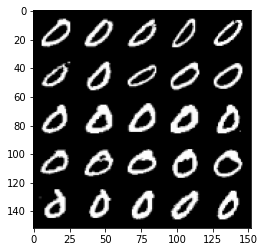

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [26]:
show_tensor_images(images)
targets

In [27]:
ch=1
dataset = TensorDataset(images, targets)
dataloader = DataLoader(dataset,batch_size=128,shuffle=True)


# **Classifier**

In [28]:
class Discriminator(nn.Module):

    def __init__(self, nodes=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
          nn.Conv2d(ch, nodes, 4, stride=2),
          nn.BatchNorm2d(nodes),
          nn.ReLU(),
           # output =13x13
          nn.Conv2d(nodes, nodes *2, 4, stride=2),
          nn.BatchNorm2d(nodes *2),
          nn.ReLU(),
          # output =5x5
          nn.Conv2d(nodes *2, 1, 4, stride=2),
          # output =1x1
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# **Training The Model:**

In [52]:
disc = Discriminator() 
criterion = nn.BCEWithLogitsLoss()
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001)


In [53]:
n_epochs = 10
running_loss=0.0
current_step=0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real,tar in tqdm(dataloader):
        disc_opt.zero_grad()
        out = disc(real)
        loss = criterion(out,tar)
        loss.backward()
        disc_opt.step()
        running_loss += loss.item()
        if current_step%60==0:
          print('[%d] loss: %.3f' %(epoch + 1, running_loss / 2000))
          running_loss = 0.0
        current_step+=1

[1] loss: 0.000
[1] loss: 0.006



[2] loss: 0.002



[3] loss: 0.001
[3] loss: 0.001



[4] loss: 0.001



[5] loss: 0.001
[5] loss: 0.001



[6] loss: 0.000



[7] loss: 0.000
[7] loss: 0.000



[8] loss: 0.000



[9] loss: 0.000
[9] loss: 0.000



[10] loss: 0.000



# **Sample Data From Training Dataset:**

it is a zero


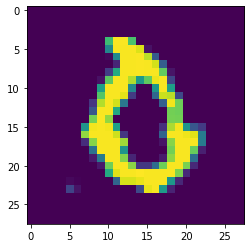

In [124]:
import random
im=random.randint(0, len(images))
plt.imshow(images[im].reshape(28,28))
if disc(images[im].reshape(1,1,28,28))>0:
  print("it is a zero")
else:
  print("it is another number")

# **Sample Data From The Original Dataset:**

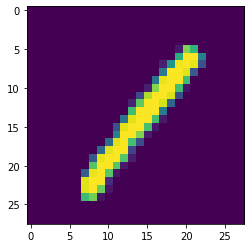

it is another number


In [141]:
import random
d=data.data.reshape(60000,1, 28, 28).float()
im=random.randint(0, len(d))
plt.imshow(d[im].reshape(28,28))
plt.show()
if disc(d[im].reshape(1,1,28,28))>0:
  print("it is a zero")
else:
  print("it is another number")

# **Calculating The Accuracy:**

In [ ]:
def get_prediction(x):
  if x>0:
    return 0
  else:
    return 1
def getlab(x):
  if x!=0:
    return 1
  else:
    return x
num_correct=0
for img,lab in data:
  predictions = get_prediction(disc(img.reshape(1,1,28,28)))
  num_correct += (predictions == getlab(lab))


In [151]:
mistakes=60000-num_correct
print("num_correct=",num_correct)
print("mistakes",mistakes)

num_correct= 59426
mistakes 574


In [152]:
Accuracy=num_correct/60000
Accuracy

0.9904333333333334

In [153]:
torch.save(disc,"zeror classifier.pt")
